# Kod för behandling av MR-data

In [11]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import os
import open3d as o3d

# Enable LaTeX-style rendering

os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

plt.rcParams["text.usetex"] = True

In [12]:
class Databehandling:
    def __init__(self, filvag_rot):
        """
        Använd roten som argument för 'filvag_rot', sedan resten av strängen som argument (där detta behövs).
        Roten ska vara filvägen fram till PatientX
        """
        self.rot = filvag_rot

    def ladda_data(self, filvag_specifik, verbose=False):
        """
        Konkatenerar strängarna till hela filvägen, laddar sedan datan från vald fil och 
        lägger nollskillda punkters koordinater och värden i varsin numpy-array.
        """
        filvag = f"{self.rot}{filvag_specifik}"
        bild = nib.load(filvag)
        data = bild.get_fdata()
        affine = bild.affine
        header = bild.header

        if verbose:
            print(header) # Information om filen från vilken datan hämtas
            
        punkter = np.array(np.nonzero(data)).T
        N = punkter.shape[0]
        varden = []
        for i in range(N):
            varden.append(data[punkter[i,0]][punkter[i,1]][punkter[i,2]])
        varden = np.array(varden)

        return data, punkter, varden, affine, header["pixdim"]
    
    def skapa_punktmoln(self, data, punkter, autoseg, visa=False):

        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(punkter)
        färger = np.zeros((len(punkter), 3))

        if autoseg == "DEEP": # Denna används om segmenteringen gjorts av DeepBraTumIA 
            # Lägger till färger till olika regioner mha RGB
            avb_färg = {
                1: [0, 0, 1],  # Blue för värdet 1
                2: [1, 0, 0],  # Red -||- 2
                3: [0, 1, 0],  # Green -||- 3
            }
        
            for label, color in avb_färg.items():
                mask = data[punkter[:, 0], punkter[:, 1], punkter[:, 2]] == label
                färger[mask] = color 

        elif autoseg == "HDGA": # Denna används om segmenteringen gjorts av HD-GLIO-AUTO

            unika_varden = np.unique(data[data > 0])  # Ta bort bakgrund
            v_min, v_max = unika_varden.min(), unika_varden.max()
            

            norm = (data - v_min) / (v_max - v_min) # För normering

            cmap = plt.get_cmap("jet")  # Färgpalett för colormapen

            for i, punkt in enumerate(punkter):
                x, y, z = punkt.astype(int) # RGB kräver (naturliga) heltal
                value = norm[x, y, z]   
                färger[i] = cmap(value)[:3] 
            
        pcd.colors = o3d.utility.Vector3dVector(färger)
        o3d.io.write_point_cloud("output.ply", pcd)

        if visa:
            o3d.visualization.draw_geometries([pcd])
            if autoseg == "HDGA":
                print(unika_varden)
        
        return pcd
    
    def skivor(self, data, pkt_koord, visualisera=False):

        for i in range(3):
            if len(pkt_koord[:,i]) % 2 == 0:
                c = int(len(pkt_koord[:,i]) / 2)
                mitt_koord.append(pkt_koord[c,i])
            else:
                d = int((len(pkt_koord[:,i]) - 1)/2)
                mitt_koord.append(pkt_koord[d,i])
        
        mitt = [data[mitt_koord[0], :, :],data[:, mitt_koord[1], :],data[:, :, mitt_koord[2]]]
        plt.imshow(mitt[2].T, cmap="gray", origin="lower")

        if visualisera:
            plt.show()

        # Verkar som /native/segmentation/ct1_seg_mask.nii.gz funkar väl med denna metod,
        # /atlas/skull_strip/ct1_skull_strip.nii.gz funkar inte lika bra då tumören inte visas i
    
    def plot_histogram(self, varden, bins=100):
        #plt.figure(figsize=(7, 5))
        plt.hist(varden, bins=bins, color='b', alpha=0.7)
        plt.xlabel("Intensitet")
        plt.ylabel("Antal voxlar")
        plt.title("Histogram över intensitetsvärden")
        plt.show()

    def segment_mot_intensitet(self, vard, data_seg, pktr):
        segment = np.unique(data_seg[data_seg > 0])

        for i in segment:
            mask = data_seg[pktr[:, 0], pktr[:, 1], pktr[:, 2]] == i
            I = vard[mask]
        
            plt.hist(I, bins=50, alpha = 0.5, label = f"Segment {i}")
        
        plt.xlabel("Intensitet")
        plt.ylabel("Antal voxlar")
        plt.title("Intensitetsfördelning hos voxlar för segmenten")
        plt.legend(loc="upper right")
        plt.show()

In [13]:
# Möjliga kombinationer av fil seg spec:
# /registered/*_r2s_bet_reg.nii.gz och /registered/segmentation.nii.gz
# /registered/*_r2s_bet.nii.gz och native/segmentation_*_origspace.nii.gz
# Om en resampling har gjorts: /registered/*_r2s_bet.nii.gz och filväg_till_resampling

# Skapa egna, beroende på hur era filvägar ser ut
fil_rot = "/Users/gustavfixell/Documents/F3/MVEX11/Kod/Data/Patient-085/"
fil_spec = "week-025/DeepBraTumIA-segmentation/atlas/skull_strip/t2_skull_strip.nii.gz" # För DeepBraTumIA: */atlas/skull_strip.nii.gz

seg_spec = "week-025/DeepBraTumIA-segmentation/atlas/segmentation/seg_mask.nii.gz" # För DeepBraTumIA: */atlas/segmentation/seg_mask.nii.gz

Behandla = Databehandling(fil_rot)

data, koord, varden, affine, pixdim = Behandla.ladda_data(fil_spec)
seg_data, seg_koord, label, seg_affine, _ = Behandla.ladda_data(seg_spec)

# dimension: mm^3
# Värdena i Niftin är [0,1,2,3] (för ct1_seg_mask.nii.gz i DeepBraTum/native iallafall) och är olika segment av tumören.
# dessa värden kan indikera olika typer av vävnad, eller liknande och kan ha lagts till manuellt. Kolla om det står nåt!

In [14]:
# Kolla att affines är samma, om inte har fel uppsättning bild/segmentering valts.
print("MRI shape:", data.shape)
print("Segmentation shape:", seg_data.shape)
print("MRI affine:\n", affine)
print("Segmentation affine:\n", seg_affine) 

MRI shape: (182, 218, 182)
Segmentation shape: (182, 218, 182)
MRI affine:
 [[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Segmentation affine:
 [[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]


In [15]:
def masscentrum_och_effektiv_radie(rho,seg_rho,h_koord,t_koord,affine,pixdim,mm=False): 
        C = len(h_koord)
        X = np.zeros(3)
        M = 0 # Initialisera totala massan som noll
        dV = np.prod(pixdim[1:4]) # Varje voxels volym

        # Effektiva radien fås genom att anta sfärisk symmteri och lösa ut radien
        R_eff = int((3*np.sum(seg_rho>0))/(4*np.pi))**(1/3)

        # Välj hjärnans mitt som origo
        if C % 2 == 0:
                origo = h_koord[int(C/2)].astype(int)
        else:
                origo = h_koord[int((C-1)/2)].astype(int)

        unika_varden = np.unique(rho[rho>0])  # Ta bort bakgrund
        v_min, v_max = unika_varden.min(), unika_varden.max()
        norm = (rho - v_min) / (v_max - v_min)

        for i, punkt in enumerate(t_koord):
                x, y, z = punkt.astype(int)
                m_i = norm[x,y,z]*dV
                M += m_i
                R = punkt-origo # Relativa vektorn mellan origo och punkten
                X = X+R*m_i
        if mm:
                X_mm = nib.affines.apply_affine(affine,X) # X i mm-refsystemet
                xbar_mm = (X_mm/M).astype(int)
                origo_mm = nib.affines.apply_affine(affine,origo)
                mc_mm = xbar_mm + origo_mm
                return mc_mm, R_eff
        
        xbar = (X/M).astype(int) # Masscentrum relativt origo
        mc = xbar + origo

        return mc, R_eff

mitt_koord, eff_rad = masscentrum_och_effektiv_radie(data,seg_data,koord,seg_koord,affine,pixdim)
print(mitt_koord)

[119  80  98]


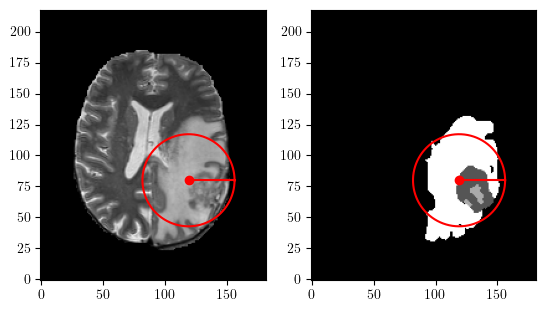

In [16]:
fig, ax = plt.subplots(1,2)
t = np.linspace(0,2*np.pi,1000)
x,y,z = mitt_koord
data_arr = [data[:, :, z],seg_data[:, :, z]]
for i, d in enumerate(data_arr):
    ax[i].imshow(d.T, cmap="gray", origin="lower",zorder=1)
    ax[i].scatter(x,y,c="r")
    ax[i].plot([x,x+eff_rad],[y,y],c="r")
    ax[i].plot(eff_rad*np.cos(t)+x,y+eff_rad*np.sin(t),c="r")
#plt.savefig("/Users/gustavfixell/Desktop/Hjärnbilder/Patient-002-week-040-2_resampled")

# Dimensioner av tumörer för valda veckor

In [ ]:
def dimfinder(base_path,path_to_img):
    patient_dirs = [d for d in os.listdir(base_path) if not d.startswith('.')] # Tar bort .DS_Store, som finns på Mac, kan ksk exkluderas på andra system.
    patient_dirs.sort()

    dims = []

    for patient in patient_dirs:
        patient_path = os.path.join(base_path, patient)
        week_dirs = [d for d in os.listdir(patient_path) if not d.startswith('.')]
        week_dirs.sort()

        for week in week_dirs:
            filvag = os.path.join(patient_path,week)+path_to_img
            img  = nib.load(filvag)

            data  = img.get_fdata()
            shape = data.shape
            zooms = img.header.get_zooms()

            print(f"{patient},{week}")
            print(f"Shape (antal voxlar): {shape}")
            print(f"Voxel dimensions (mm): {zooms}")
            #tup = (shape,zooms)
            #dims.append(tup)

    # return dims


# Användning
bas = "/Users/gustavfixell/Documents/F3/MVEX11/Kod/Utvald"
spec = "/DeepBraTumIA-segmentation/atlas/skull_strip/t2_skull_strip.nii.gz"

dimfinder(bas,spec)

Patient-004,week-000-2
Shape (antal voxlar): (182, 218, 182)
Voxel dimensions (mm): (np.float32(1.0), np.float32(1.0), np.float32(1.0))
Patient-004,week-020
Shape (antal voxlar): (182, 218, 182)
Voxel dimensions (mm): (np.float32(1.0), np.float32(1.0), np.float32(1.0))
Patient-004,week-038
Shape (antal voxlar): (182, 218, 182)
Voxel dimensions (mm): (np.float32(1.0), np.float32(1.0), np.float32(1.0))
Patient-004,week-041
Shape (antal voxlar): (182, 218, 182)
Voxel dimensions (mm): (np.float32(1.0), np.float32(1.0), np.float32(1.0))
Patient-015,week-000-2
Shape (antal voxlar): (182, 218, 182)
Voxel dimensions (mm): (np.float32(1.0), np.float32(1.0), np.float32(1.0))
Patient-015,week-021
Shape (antal voxlar): (182, 218, 182)
Voxel dimensions (mm): (np.float32(1.0), np.float32(1.0), np.float32(1.0))
Patient-015,week-037
Shape (antal voxlar): (182, 218, 182)
Voxel dimensions (mm): (np.float32(1.0), np.float32(1.0), np.float32(1.0))
Patient-015,week-056
Shape (antal voxlar): (182, 218, 182)

# Visualisering av tumör (start och slut) och manuell extraktion av data

✅ Reference week: week-025, Z-slice: 101, Z-mm: 29.00


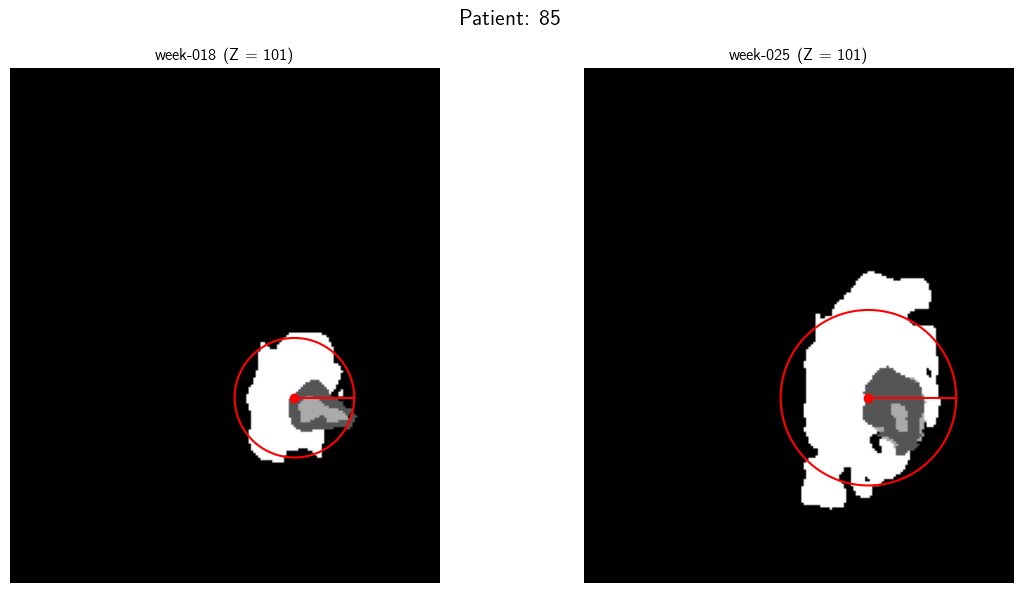

[25.331582673729542, 37.17641585247257]
[120  78 101]


In [27]:
# Base paths
patient = "Patient-085/"
patient_path = os.path.join('/Users/gustavfixell/Documents/F3/MVEX11/Kod/Data',patient)
weeks = ['week-018', 'week-025']
dBehan = Databehandling(patient_path)

# --- Step 1: Find reference Z-center in mm (using seg of first available week) ---
ref_z_mm = None
ref_week = None
eff_rads = []

for i,week in enumerate(weeks):
    t2_path = os.path.join(week, 'DeepBraTumIA-segmentation', 'atlas', 'skull_strip', 't2_skull_strip.nii.gz')
    seg_path = os.path.join(week, 'DeepBraTumIA-segmentation', 'atlas', 'segmentation', 'seg_mask.nii.gz')

    dAta, kOord, _, aFfine, pIxdim = dBehan.ladda_data(t2_path)
    sEg_data, sEg_koord, _, _, _ = dBehan.ladda_data(seg_path)
    if i == 0:
        centerofmass, Re = masscentrum_och_effektiv_radie(dAta,sEg_data,kOord,sEg_koord,aFfine,pIxdim)
        center_x, center_y, center_z = centerofmass 
        ref_z_mm = aFfine @ [0, 0, center_z, 1]  # mm coordinates
        ref_week = week
        eff_rads.append(Re)

    elif i == 1:
        _, Re = masscentrum_och_effektiv_radie(dAta,sEg_data,kOord,sEg_koord,aFfine,pIxdim)
        eff_rads.append(Re)

print(f"✅ Reference week: {week}, Z-slice: {center_z}, Z-mm: {ref_z_mm[2]:.2f}")

if ref_z_mm is None:
    print("⚠️ No reference slice found.")
else:
    # --- Step 2: Plot both weeks at the same mm slice ---
    fig, ax = plt.subplots(1, len(weeks), figsize=(12, 6))

    for i, week in enumerate(weeks):
        #t2_path = os.path.join(patient_path, week, 'DeepBraTumIA-segmentation', 'atlas', 'skull_strip', 't2_skull_strip.nii.gz')
        t2_path = os.path.join(patient_path, week, 'DeepBraTumIA-segmentation', 'atlas', 'segmentation', 'seg_mask.nii.gz')

        if not os.path.exists(t2_path):
            ax[i].set_title(f"{week}\nMissing T2")
            ax[i].axis('off')
            continue

        img = nib.load(t2_path)
        data = img.get_fdata()


        # ax[i].imshow(np.rot90(data[:, :, center_z]), cmap='gray')
        # ax[i].set_title(f"{week} (Z = {center_z})")
        # ax[i].axis('off')
        t = np.linspace(0,2*np.pi,1000)
        ax[i].imshow(data[:, :, center_z].T, cmap="gray", origin="lower",zorder=1)
        ax[i].scatter(center_x,center_y,c="r")
        ax[i].plot([center_x,center_x+eff_rads[i]],[center_y,center_y],c="r")
        ax[i].plot(eff_rads[i]*np.cos(t)+center_x,center_y+eff_rads[i]*np.sin(t),c="r")
        ax[i].set_title(f"{week} (Z = {center_z})")
        ax[i].axis('off')

    plt.suptitle("Patient: 85", fontsize=16)
    plt.tight_layout()
    plt.show()
    print(eff_rads)
    print(centerofmass)

In [29]:
patienter = np.array(["Patient 23", "Patient 32", "Patient 34", "Patient 42", "Patient 60", "Patient 85", "Patient 86"]).reshape(-1, 1)
effektiva = np.array([18.07,15.51,19.81,19.29,13.80,25.33,31.28]).reshape(-1, 1)
massc = np.array([[119,90,58],[70,55,97],[46,77,106],[130,101,69],[68,114,125],[120,78,101],[53,75,103]])
grejer = np.hstack([patienter,effektiva,massc])

df = pd.DataFrame(grejer, columns=['Patient ID', 'Initial eff. radie', 'Initialt masscentrum (x)', 'Initialt masscentrum (y)', 'Initialt masscentrum (z)'])
df.to_csv('/Users/gustavfixell/Documents/F3/MVEX11/Kod/Preprocessing/CSVfiler/mc_och_effR_utvalda.csv', index=False)